In [1]:
import os
import operator
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain.output_parsers import PydanticOutputParser
from firecrawl import FirecrawlApp, JsonConfig


load_dotenv()

True

In [2]:
os.environ["HF_API_KEY"]=os.getenv("HF_API_KEY")
os.environ["GEMINI_API_KEY"]=os.getenv("GEMINI_API_KEY")
webcrawl_key=os.getenv("FIRECRAWL_API_KEY")


model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
loader=DirectoryLoader("data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

pages=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in pages]
vectordb=Chroma.from_documents(pages,embeddings)

retriever=vectordb.as_retriever(search_kwargs={"k": 3})

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')


parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


/Users/anujpandey/llm_projects/agentic_2.0_projects/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import re

def extract_domain(prompt: str):
    # Match domain names like 'screener.in', 'screen.in', etc.
    match = re.search(r'([a-zA-Z0-9\-]+\.[a-zA-Z]{2,})', prompt)
    if match:
        return match.group(1)
    return None

In [ ]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [INDIA,Not Related,WEBLINK]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})      
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "india" in last_message.lower():
        return "RAG Call"
    elif "weblink" in last_message.lower():
        return "CRAWL Call"
    else:
        return "LLM Call"

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

def function_4(state:AgentState):
    print("-> CRAWL Call ->")
    question = state["messages"][0]
    class ExtractSchema(BaseModel):
        company_mission: str
        business_overview: str

    json_config = JsonConfig(
        schema=ExtractSchema
    )
    app = FirecrawlApp(api_key=webcrawl_key)
    domain=extract_domain(question)
    # Scrape a website:
    scrape_result = app.scrape_url(domain, formats=['json'],json_options=json_config)
    return {"messages": [scrape_result.json]}

In [5]:
function_4({"messages":["crawl website screen.in"]})

-> CRAWL Call ->


{'messages': [{'company_mission': "This domain name (without content) may be available for sale or lease by its owner through Bodis's domain sales platform.",
   'business_overview': 'The domain name screen.in may be available for sale or lease.'}]}

In [11]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("CRAWL",function_4)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "CRAWL Call": "CRAWL",
    }
)
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
workflow.add_edge("CRAWL",END)

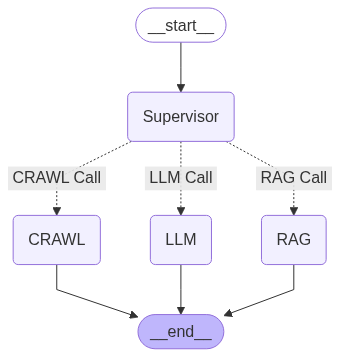

In [12]:
workflow.compile()

In [14]:
app=workflow.compile()



In [18]:
state={"messages":["get me information from abndh34.com"]}
result=app.invoke(state)
print(result["messages"][-1])

Question get me information from abndh34.com
Parsed response: Topic='WEBLINK' Reasoning='The query explicitly asks for information from a specific website URL.'
-> ROUTER ->
last_message: WEBLINK
-> CRAWL Call ->


HTTPError: Internal Server Error: Failed to scrape URL. (Internal server error) - DNS resolution failed for hostname: abndh34.com. Please check if the domain is valid and accessible. - No additional error details provided.